<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a>
##  Première étape:  étude des variables "métier"

## 1 Introduction
### 1.1 Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone, objet connecté précurseur et dont la fonctionnalité de téléphonie devient très secondaire.
Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)]().
Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

Elle contient également deux fichiers "train" et "test" de *features* ou variables métier calculées dans les domaines temporels et fréquentiels: 561 variables.

Les données sont labellisées avec 6 activités: debout, assis, couché, marche, monter ou descendre un escalier. Il s'agit donc, en première lecture, d'un problème de classification supervisée (6 classes) avec 10299 observations (apprentissage  et test) décrites par 561 variables.

Voici une liste indicative des variables calculées sur chacune des variables initiales et couples de variables:

Name|Signification
-|-
mean | Mean value
std | Standard deviation
mad | Median absolute value
max | Largest values in array
min | Smallest value in array
sma | Signal magnitude area
energy | Average sum of the squares
iqr | Interquartile range
entropy | Signal Entropy
arCoeff | Autorregresion coefficients
correlation | Correlation coefficient
maxFreqInd | Largest frequency component
meanFreq | Frequency signal weighted average
skewness | Frequency signal Skewness
kurtosis | Frequency signal Kurtosis
energyBand | Energy of a frequency interval
angle | Angle between two vectors

### 1.2 Objectifs
Cette *première étape* s'intéresse aux seules variables construites à partir des connaissances *a priori* du comportement des capteurs en fonction des types d'activité humaine. Ce premier calepin propose une exploration et une modélisation, des 561 variables métier. Il s'agit de répondre à la question: quel algorihtme d'apprentissage permet de déterminer au mieux l'activité humaine? 

Une *deuxième étape*  s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant, par exemple, des décompositions systématiques sur une base d'ondelettes ou mieux un algorihtme d'apprentissage profond sur les seules données brutes? L'enjeu est d'obtenir une discrimination sur les données brutes donc moins énergivores qu'un calcul préalable des caractéristiques métier.

In [1]:
# Graphiques dans la fenêtre
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
sys.version

'3.5.3 |Anaconda custom (x86_64)| (default, Mar  6 2017, 12:15:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## 2 Lecture des données

Les données peuvent être préalablement téléchargées ou directement lues. Ce sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). 

In [2]:
# Lecture des données d'apprentissage
# Attention, il peut y avoir plusieurs espaces comme séparateur
Xtrain=pd.read_table("X_train.txt",sep='\s+',header=None)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [3]:
ytrain=pd.read_table("y_train.txt",sep='\s+',header=None,names=('y'))
# Le type dataFrame est inutile et même gênant pour les la suite
ytrain=ytrain["y"]

In [4]:
# Lecture des données de test
# Attention, il peut y avoir plusieurs espaces comme séparateur
Xtest=pd.read_table("X_test.txt",sep='\s+',header=None)
Xtest.shape

(2947, 561)

In [5]:
ytest=pd.read_table("y_test.txt",sep='\s+',header=None,names=('y'))
ytest=ytest["y"]

## 3 Exploration
### 3.1 [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
Il est important de se faire une idée précise de la structure des données.  Une analyse en composantes principales est adaptée à cet objectif.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

La fonction ci-après construit la représentation graphique d'un plan factoriel.

In [7]:
label_dic = {1 : "Marcher",2 : "Monter escalier",3 : "Descendre escalier",
   4 : "Assis",5 : "Debout",6 : "Couche"}
labels = label_dic.values()
def plot_pca(X_R,fig,ax,nbc,nbc2):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=1, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=10)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=10)

In [8]:
pca = PCA()
# Composantes principales
X_r = pca.fit_transform(Xtrain)

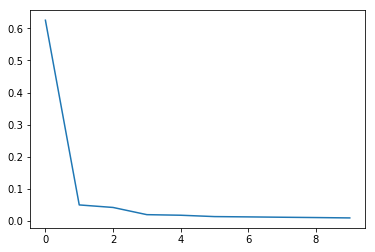

In [9]:
# Décroissance des premières valeurs propres
plt.plot(pca.explained_variance_ratio_[0:10])
plt.show()

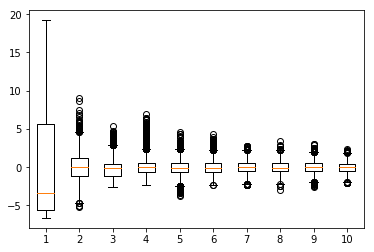

In [10]:
# Distribution des premières composantes principales
plt.boxplot(X_r[:,0:10])
plt.show()

**Q** Combien choisir de composantes?

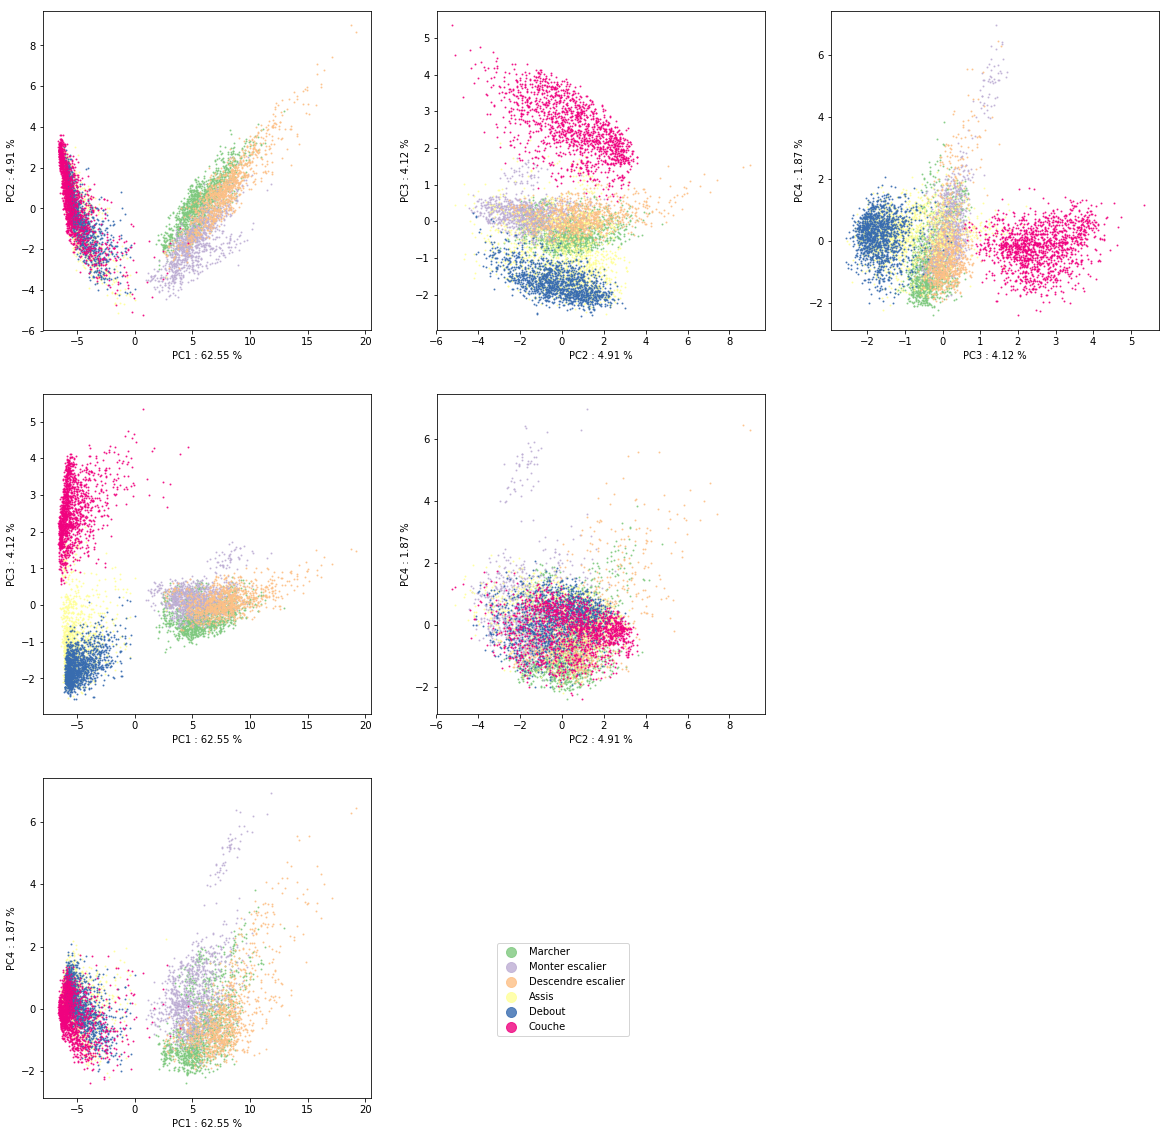

In [11]:
cmaps = plt.get_cmap("Accent")

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_r, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q** Commenter la séparation des deux types de situation par le premier axe.

**Q** Que dire sur la forme des nuages?

**Q** Que dire sur la plus ou moins bonne séparation des classes?


Les graphiques des variables sont illisibles compte tenu de leur trop grand nombre. Ce n'est pas indispensable mais intéressant de chercher quelques variables les plus influentes des axes factoriels. 

#### Variables de l'ACP
Lecture des libellés des variables et constitution d'une liste.

In [12]:
with open('features.txt', 'r') as content_file:
    featuresNames = content_file.read()
columnsNames = list(map(lambda x : x.split(" ")[1],featuresNames.split("\n")[:-1]))

Représentation des variables... c'est évidemment illisible en mettant les libellés en clair. Seul un point "." est représenté.

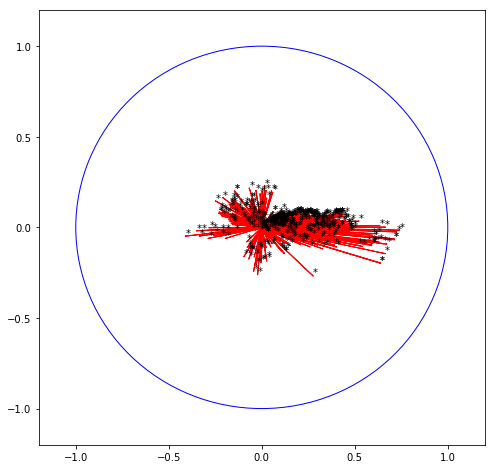

In [13]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j in zip(coord1,coord2, ):
    plt.text(i, j, "*")
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

In [14]:
np.array(columnsNames)[abs(coord1)>1]

array([], 
      dtype='<U36')

### 3.2 [Analyse Factorielle Discriminante (AFD)](http://wikistat.fr/pdf/st-m-explo-afd.pdf)
L'ACP ne prend pas en compte la présence de la variable qualitative à modéliser contrairement à l'analyse factorielle discriminante qui calcule l'ACP des barycentres des classes. De plus l'espace des indivudus est muni d'une métrique spécifique: *Mahalanobis*. L'objectif est alors de visualiser les capacités des variables à discriminer les classes.

La librairie `scikit-learn` ne propose pas de fonction spécifique d'analyse factorielle discriminante mais les coordonnées des individus dans la base des vecteurs discriminants sont obtenues comme résultats de l'analyse discriminante linéaire décisionnnelle. Cette dernière sera utilisé avec une finalité prédictive dans un deuxième temps.

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


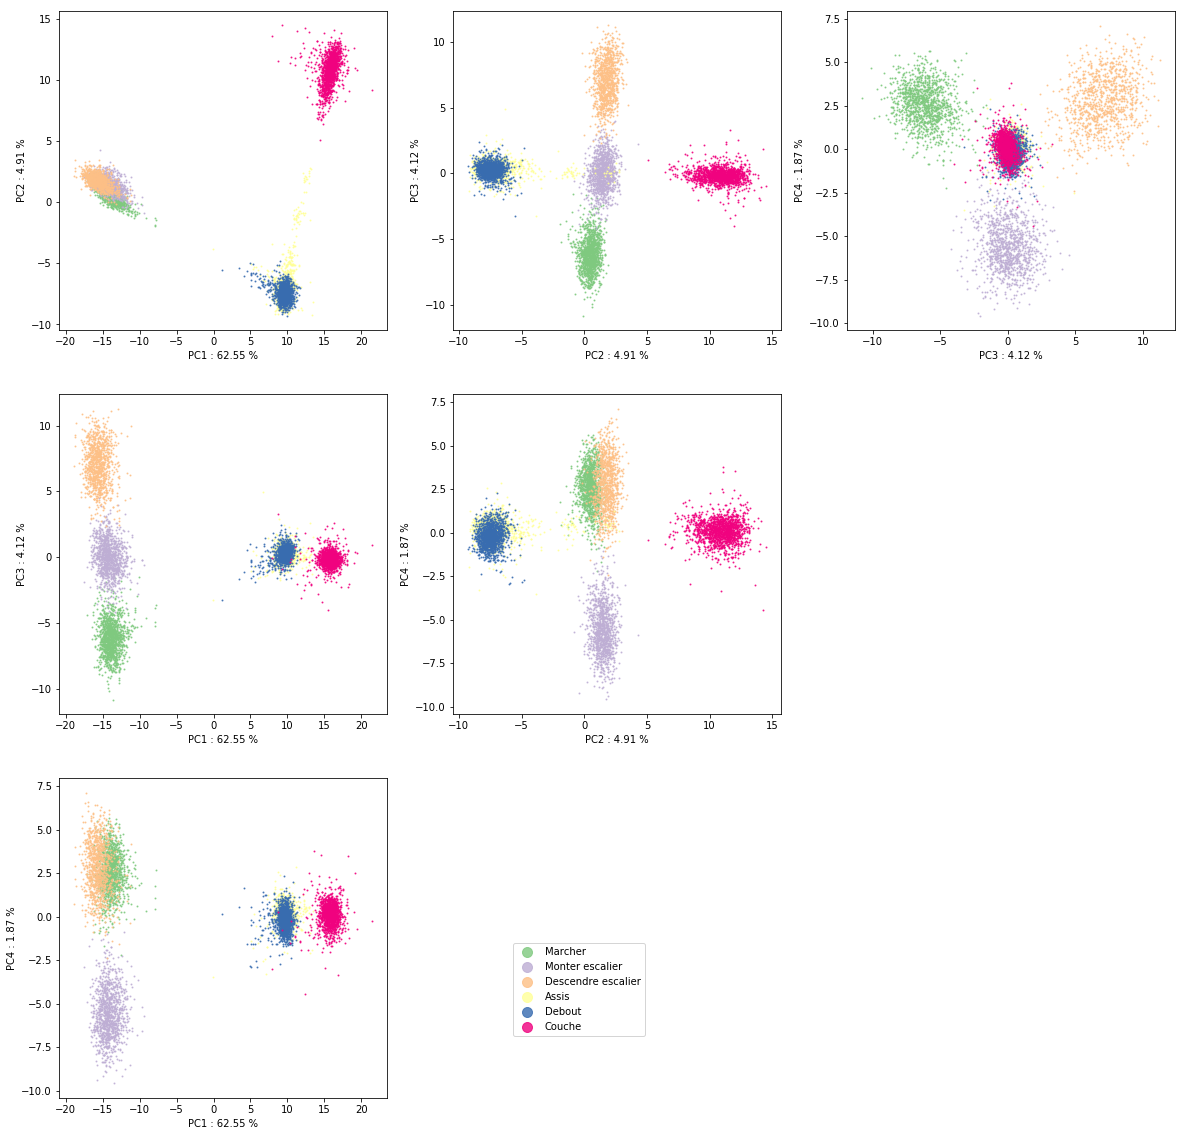

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
method = LinearDiscriminantAnalysis() 
lda=method.fit(Xtrain,ytrain)
X_r2=lda.transform(Xtrain)

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_r2, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q** Que dire de la séparation des classes. Sont-elles toutes séparables deux à deux?

**Q** Que dire de la forme des nuages notamment dans le premier plan?

Il serait opportun de réfléchir à la représentation des variables dans les axes discriminants.

### 3.3 Classification non supervisée
Cette section n'est pas utile puisque les classes sont connues mais elle permet d'illusrer le comportement de deux alorithmes de classification non supervisée. Comparer dans une matrice de confusion les classes obtenues avec celles connues permet d'en comparer les performances.
#### $k$*-means*
Attention, il est nécessaire de centrer et réduire les variables avant d'exécuter un algorithle de classification non supervisé.

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
tps1 = time.clock()
X = StandardScaler().fit_transform(Xtrain)
km=KMeans(n_clusters=6, n_jobs=1)
km.fit(Xtrain)
tps2 = time.clock()
print("Temps execution Kmeans :", (tps2 - tps1))

Temps execution Kmeans : 12.462446


In [17]:
pd.DataFrame(confusion_matrix(ytrain, km.labels_)[1:7,0:6], columns=labels)

NameError: name 'confusion_matrix' is not defined

#### *DBSCAN*

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
tps1 = time.clock()
db = DBSCAN(eps=4, min_samples=5).fit(X)
tps2 = time.clock()
print("Temps execution Kmeans :", (tps2 - tps1))

In [ ]:
import pandas as pd
pd.DataFrame(db.labels_).plot(kind="hist")

## 4 Apprentissage et prévision de l'échantillon test
Un échantillon test est fourni avec les donées. Cet échantillon est utilisé pour estimer une erreur de prévision comparable avec la littérature. Néanmoins, il serait opportun de d'exécuter une validation croisée *Monte Carlo*. Certes l'échantillon test est de taille raisonnable (2947) mais comme les prévision sont très bonnes, les comparaisons ne reposent que sur le plus ou moins bon classement de quelques situations parmi les 2947.

Différentes méthodes sont successivement testées.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### 4.1 [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)
Une méthode ancienne mais finalement bien adaptée aux données. Une première approche est réalisée sans sélection de variables. 

**Q** Alors que la régression logistique est adaptée à la prévision d'une variable binaire, quelle la stratégie utilisée par défaut pour l'appliquer à une variable qualitative à 6 classes.

In [ ]:
ts = time.time()
method = LogisticRegression()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Sélection par pénalisation Lasso et optimisation du paramètre par validation croisée.

*Attention* C'est un peu long!

In [ ]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
ts = time.time()
param=[{"C":[0.5,1,5,10,12,15,30]}]
logit = GridSearchCV(LogisticRegression(penalty="l1"), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(Xtrain, ytrain)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

In [ ]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_))

In [ ]:
yChap = logitOpt.predict(Xtest)
# matrice de confusion
logitOpt.score(Xtest, ytest)

In [ ]:
pd.DataFrame(confusion_matrix(ytest, yChap), index = labels, columns=labels)

**Q** L'amélioration est-elle bien significative?

### 4.2 [Analyse discriminante linéaire](http://wikistat.fr/pdf/st-m-app-add.pdf)
**Q** Que dire de l'optimisation de cette métode? Celle-ci est proposée dans une librairie de R mais pas disponible en python.

**Q** L'analyse discriminante quadratique bloque et ne fournit pas de résultats. Pourquoi?

**Q** Quel paramètre de cet algortihme pourrait être optimisé?

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

ts = time.time()
method = LinearDiscriminantAnalysis()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
score

/Users/bguillouet/anaconda/envs/TPInsa/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.96233457753647778

In [22]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.962335, time running : 0 secondes


NameError: name 'confusion_matrix' is not defined

### 4.3 [*K* plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)

Cette méthode peut être vue comme un cas particulier d'analyse discriminante avec une estimation locale des fonctions de densité conditionnelle. 

In [ ]:
ts = time.time()
method = KNeighborsClassifier(n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

**Q** Les résultats obtenus méritent-ils de lancer une optimisation de $k$?

### 4.4 [*Random forest*](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Q** Quel serait le paramètre à optimiser?

In [ ]:
ts = time.time()
method = RandomForestClassifier(n_estimators=200,n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

### 4.5 [*Gradient boosting*](http://wikistat.fr/pdf/st-m-app-agreg.pdf)
**Q** Quels seraient les paramètres à optimiser?

In [ ]:
ts = time.time()
method = GradientBoostingClassifier()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

**Q** Cela vaut-il la peine de chercher à optimiser les paramètres? De tester l'*extrem gradient boosting*?

### 4.6 [SVM linéaire](http://wikistat.fr/pdf/st-m-app-svm.pdf)

**Q** Est-il utile d'optimiser le paramètre de pénalisation dans le cas linéaire? Pourquoi?

In [ ]:
ts = time.time()
method = LinearSVC()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

### 4.7 [SVM avec noyau gaussien](http://wikistat.fr/pdf/st-m-app-svm.pdf)

Apprentissage avec les valeurs par défaut puis optimisation des paramètres.

**Q** Quels sont les paramètres à optimiser?

In [ ]:
ts = time.time()
method = SVC()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

In [ ]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

In [ ]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xtrain, ytrain)
te = time.time()
te-ts

In [ ]:
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

**Q** Comparer les deux approches par SVM (linéaire et radiale): temps de calcul et performance.

### 4.9 Combinaison de modèles
Les formes des nuages de chaque classe observées dans le premier plan de l'analyse en composantes principales montrent que la structure de covariance n'est pas identique dans chaque classe. Cette remarque suggèrerait de s'intéresser à l'analyse discriminante quadratique mais celle-ci bloque sur l'estimation six matrices de covariance et de leurs inverses. Néanmoins il semble que, plus précisément, deux groupes se distinguent: les classes actives (marcher, monter ou descendre un escalier) d'une part et les classes passives (couché, assis, debout) d'autre part et, qu'à l'intérieur de chaque groupe les variances sont assez similaires. 

Cette situaiton suggère de construire une décision en deux étapes ou hiérarchique:
    1. Régression logistique prévoyant l'activité passive *vs.* active,
    2. Analyse discriminante linéaire spécifique à chacun de ces deux cas.
dans le même ordre idée, il est facile de remarquer que les deux classes difficiles à séparées sont "assis" et "debout". Il peut être intéressant de se focaliser sur cette question.

Extraction des données spécifiques à ces deux classes.

In [ ]:
XtrSitStan = Xtrain.loc[(ytrain[:] == 4) | (ytrain[:] == 5)]
XtestSitStan = Xtest.loc[(ytest[:] == 4) | (ytest[:] == 5)] 
ytrSitStan = (ytrain.loc[(ytrain[:] == 4) | (ytrain[:] == 5)])
ytestSitStan = (ytest.loc[(ytest[:] == 4) | (ytest[:] == 5)]) 

In [ ]:
param=[{"C":[5,6,7],"gamma":[.05,.06,.07]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOptSitStand=svm.fit(XtrSitStan, ytrSitStan)

In [ ]:
score = svmOptSitStand.best_score_
print("Meilleur score = %f, Meilleurs paramètres = %s" % (score,svmOptSitStand.best_params_))

In [ ]:
yChap = svmOptSitStand.predict(XtestSitStan)
svmOptSitStand.score(XtestSitStan, ytestSitStan)

In [ ]:
pd.DataFrame(confusion_matrix(yChap, ytestSitStan))